In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import string
import nltk
nltk.download('stopwords')


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

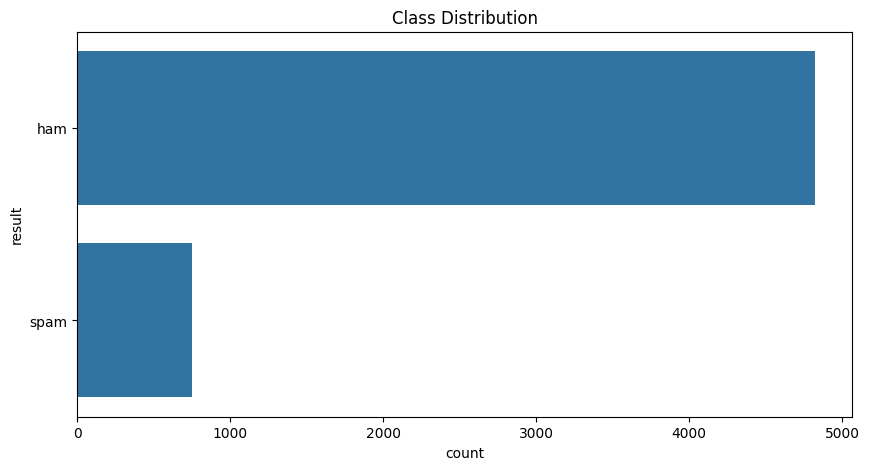

In [2]:
# Load dataset from Google Drive
file_path = '/content/drive/MyDrive/spam.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Drop unnecessary columns
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# Rename columns for better understanding
df.rename(columns={"v1": "result", "v2": "messages"}, inplace=True)

# Check for missing values
df.isna().sum()

# Data cleaning and preprocessing
stemmer = PorterStemmer()
stop = set(stopwords.words('english'))
corpus = []
for i in range(len(df)):
    review = re.sub('[^a-zA-Z0-9]', ' ', df.iloc[i]["messages"])
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(word) for word in review if word not in stop]
    review = ' '.join(review)
    corpus.append(review)

# Add processed text to the dataframe
df['processed_messages'] = corpus

# Visualize the class distribution
plt.figure(figsize=(10,5))
sbn.countplot(df['result'])
plt.title('Class Distribution')
plt.show()


In [3]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_messages']).toarray()
y = df['result'].map({'ham': 0, 'spam': 1}).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')


Training set shape: (4457, 5000)
Testing set shape: (1115, 5000)


In [4]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'--- {name} ---')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
    print(f'Classification Report:\n {classification_report(y_test, y_pred)}')
    print('\n')

# Hyperparameter tuning for the best model (example: Logistic Regression)
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Best parameters and accuracy
print(f'Best Parameters: {grid.best_params_}')
print(f'Best Score: {grid.best_score_}')

# Evaluate the tuned model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(f'--- Tuned Logistic Regression ---')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')


--- Logistic Regression ---
Accuracy: 0.9479820627802691
Confusion Matrix:
 [[961   4]
 [ 54  96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.64      0.77       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



--- Random Forest ---
Accuracy: 0.97847533632287
Confusion Matrix:
 [[964   1]
 [ 23 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



--- Gradient Boosting ---
Accuracy: 0.9730941704035875
Confusion Matrix:
 [[963   2]
 [ 28 122]]
Classif

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   2.7s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=1

In [5]:
# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X, y, cv=10)
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {np.mean(cv_scores)}')


Cross-validation scores: [0.99103943 0.97311828 0.98384201 0.98563734 0.97845601 0.98204668
 0.98384201 0.98025135 0.97845601 0.98025135]
Average cross-validation score: 0.9816940470904679


In [8]:
# Initialize stemmer and preprocess text for Word2Vec
stemmer = PorterStemmer()
stop = set(stopwords.words('english'))
corpus = []
for i in range(len(df)):
    review = re.sub('[^a-zA-Z0-9]', ' ', df.iloc[i]["messages"])
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(word) for word in review if word not in stop]
    corpus.append(review)

# Convert corpus to Word2Vec vectors
def get_vector(tokens, model):
    # Filter out tokens not in the model's vocabulary
    valid_words = [model.wv[word] for word in tokens if word in model.wv]
    if len(valid_words) > 0:
        return np.mean(valid_words, axis=0)
    else:
        # Return a zero vector if no valid words are found
        return np.zeros(model.vector_size)

# Generate Word2Vec vectors for each message
X_word2vec = np.array([get_vector(tokens, model) for tokens in corpus])
X_word2vec = np.nan_to_num(X_word2vec)  # Replace NaN values with 0

# Split the dataset into training and testing sets
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print(f'Training set shape (Word2Vec): {X_train_w2v.shape}')
print(f'Testing set shape (Word2Vec): {X_test_w2v.shape}')


Training set shape (Word2Vec): (4457, 20)
Testing set shape (Word2Vec): (1115, 20)


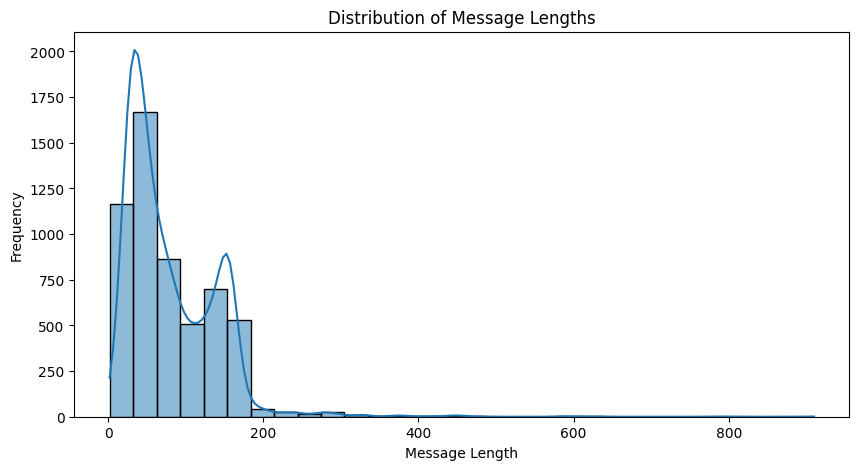

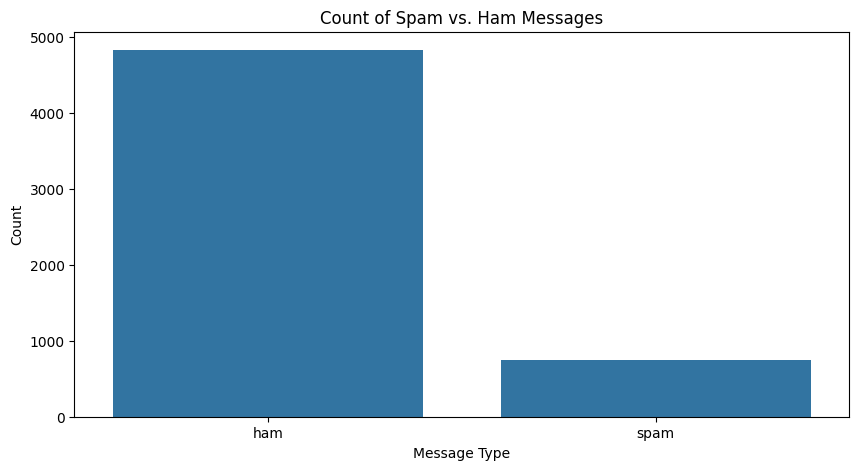

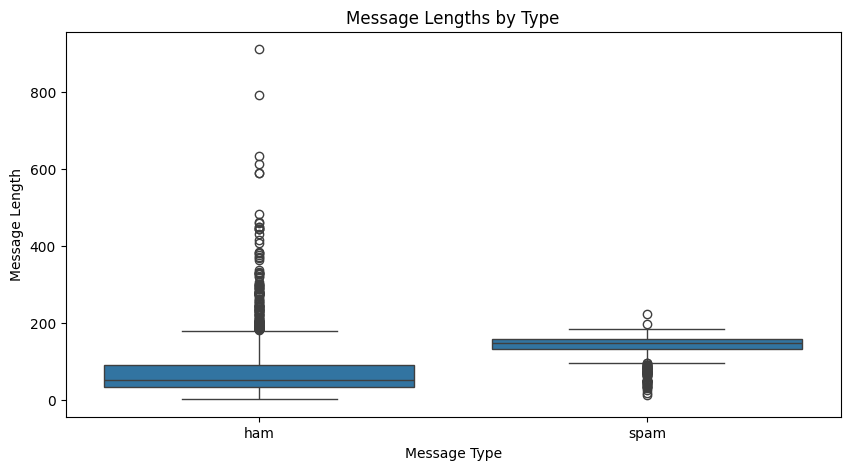

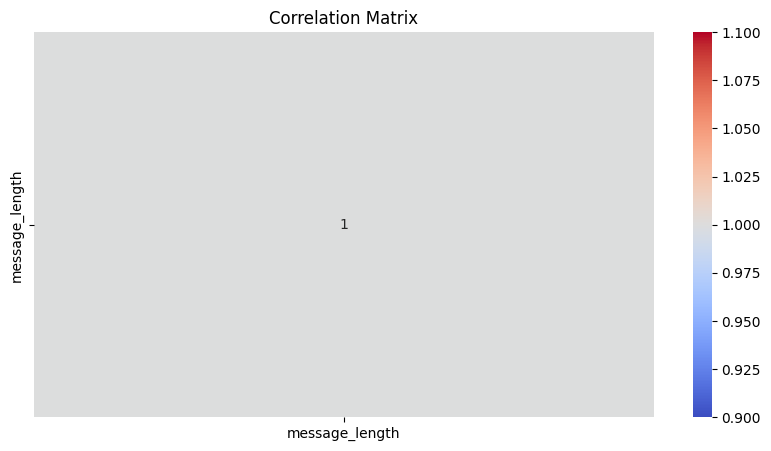

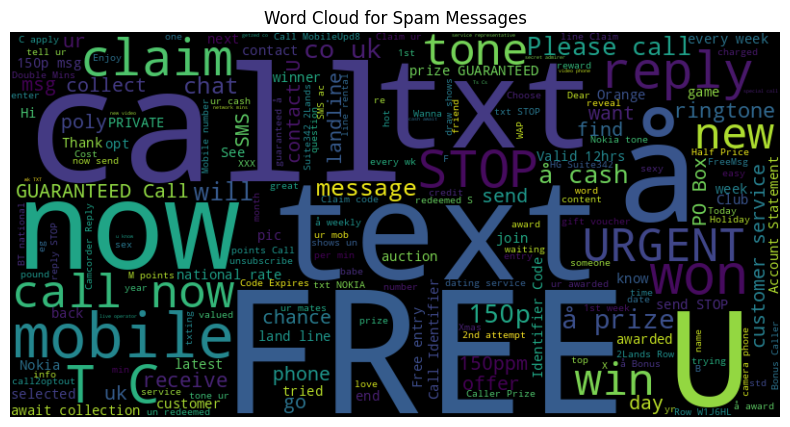

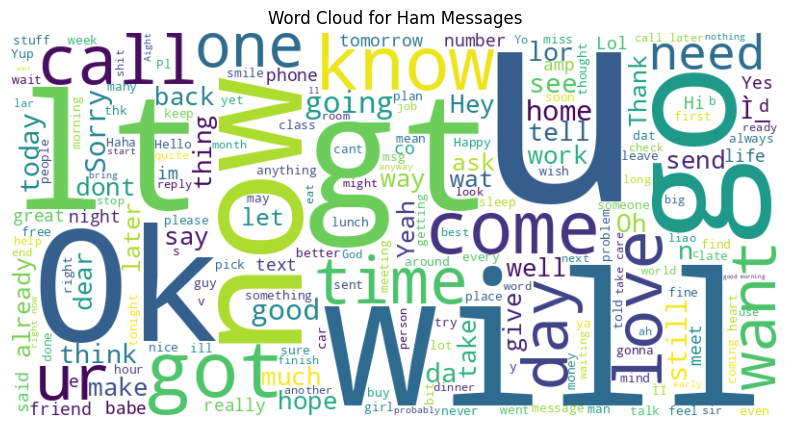

In [9]:
import seaborn as sns

# Histogram of message lengths
df['message_length'] = df['messages'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df['message_length'], bins=30, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# Count plot of spam vs. ham
plt.figure(figsize=(10,5))
sns.countplot(x='result', data=df)
plt.title('Count of Spam vs. Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

# Box plot of message lengths for spam vs. ham
plt.figure(figsize=(10,5))
sns.boxplot(x='result', y='message_length', data=df)
plt.title('Message Lengths by Type')
plt.xlabel('Message Type')
plt.ylabel('Message Length')
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(10,5))
corr_matrix = df[['message_length']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Word cloud for spam messages
from wordcloud import WordCloud

spam_words = ' '.join([text for text in df[df['result'] == 'spam']['messages']])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(spam_words)

plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()

# Word cloud for ham messages
ham_words = ' '.join([text for text in df[df['result'] == 'ham']['messages']])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')
plt.show()


In [10]:
# Initialize classifiers
classifiers_w2v = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate classifiers with Word2Vec features
for name, clf in classifiers_w2v.items():
    clf.fit(X_train_w2v, y_train)
    y_pred_w2v = clf.predict(X_test_w2v)
    print(f'--- {name} (Word2Vec) ---')
    print(f'Accuracy: {accuracy_score(y_test, y_pred_w2v)}')
    print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred_w2v)}')
    print(f'Classification Report:\n {classification_report(y_test, y_pred_w2v)}')
    print('\n')


--- Logistic Regression (Word2Vec) ---
Accuracy: 0.8825112107623319
Confusion Matrix:
 [[955  10]
 [121  29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       965
           1       0.74      0.19      0.31       150

    accuracy                           0.88      1115
   macro avg       0.82      0.59      0.62      1115
weighted avg       0.87      0.88      0.85      1115



--- Random Forest (Word2Vec) ---
Accuracy: 0.9560538116591928
Confusion Matrix:
 [[955  10]
 [ 39 111]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       965
           1       0.92      0.74      0.82       150

    accuracy                           0.96      1115
   macro avg       0.94      0.86      0.90      1115
weighted avg       0.95      0.96      0.95      1115



--- Gradient Boosting (Word2Vec) ---
Accuracy: 0.9399103139013453
Confusion Matr